In [1]:
import matplotlib

import numpy as np
import networkx as nx
import graph_tool.all as gt

from aann.dataset import Dataset
from more_itertools import flatten
from aann.utils.graph import get_model_graph, nx2gt

from aann.models import SimpleModel
from aann.utils.image import cv2pil, scale_image

/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:1544: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


In [2]:
def show_image(dataset_item: dict):
    image = dataset_item["img_features"].numpy()
    image = (image * 128).astype("uint8")
    image = image.reshape(8, 8)
    display(cv2pil(scale_image(image, (256, 256))))

In [3]:
def show_graph(gt_graph: gt.Graph):
    state = gt.minimize_nested_blockmodel_dl(
        gt_graph,
        state_args=dict(clabel=gt_graph.vp.layer)
    )

    _ = state.draw(
        bg_color="black",
        vertex_text=gt_graph.vp.neuron,
        vertex_fill_color=gt_graph.vp.layer,
        output_size=(768, 768),
        beta=0.5,
        rel_order=gt_graph.vp.neuron,
        vcmap=(matplotlib.cm.Set3, 1.0),
        edge_gradient=[],
        edge_color=gt.prop_to_size(gt_graph.ep.weight, power=2),
        ecmap=(matplotlib.cm.magma, 1.0),
    )

In [4]:
def get_node_map_by_layer(nx_graph: nx.DiGraph, layer: int) -> dict:
    node_map = {
        data["neuron"]: node for node, data in nx_graph.nodes(data=True)
        if data["layer"] == layer
    }

    return node_map

In [5]:
dataset = Dataset()
dataset.load()

In [6]:
num_classes = dataset.num_classes
print(f"num_classes => {num_classes}")

model_name = "model_50e_d07_lr1e-2"
model = SimpleModel(
    num_in_features=dataset.num_in_features,
    num_classes=dataset.num_classes,
    max_epochs=50,
    model_name=model_name,
    # device="cpu",
    
)

num_classes => 3


In [7]:
model.train(train_dp_dataset=dataset.train)
model.save()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ lin_out │ Linear            │    192 │
│ 1 │ ce_loss │ CrossEntropyLoss  │      0 │
│ 2 │ f1      │ MulticlassF1Score │      0 │
└───┴─────────┴───────────────────┴────────┘

Trainable params: 192                                                                                              
Non-trainable params: 0                                                                                            
Total params: 192                                                                                                  
Total estimated model params size (MB): 0

Output()

`Trainer.fit` stopped: `max_epochs=50` reached.


In [8]:
model.load()
model.model

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Model(
  (lin_out): Linear(in_features=64, out_features=3, bias=False)
  (ce_loss): CrossEntropyLoss()
  (f1): MulticlassF1Score()
)

In [9]:
nx_graph = get_model_graph(model, min_weight=0.6)

print(f"nodes: {nx_graph.number_of_nodes() - nx.number_of_isolates(nx_graph)}")
print(f"edges: {nx_graph.number_of_edges()}")

nodes: 34
edges: 42


In [10]:
# active_l1_nodes = [
#     data["neuron"] for node, data in nx_graph.nodes(data=True)
#     if data["layer"] == 0 and nx_graph.degree(node)
# ]

# active_l1_nodes

In [11]:
gt_graph = nx2gt(nx_graph)

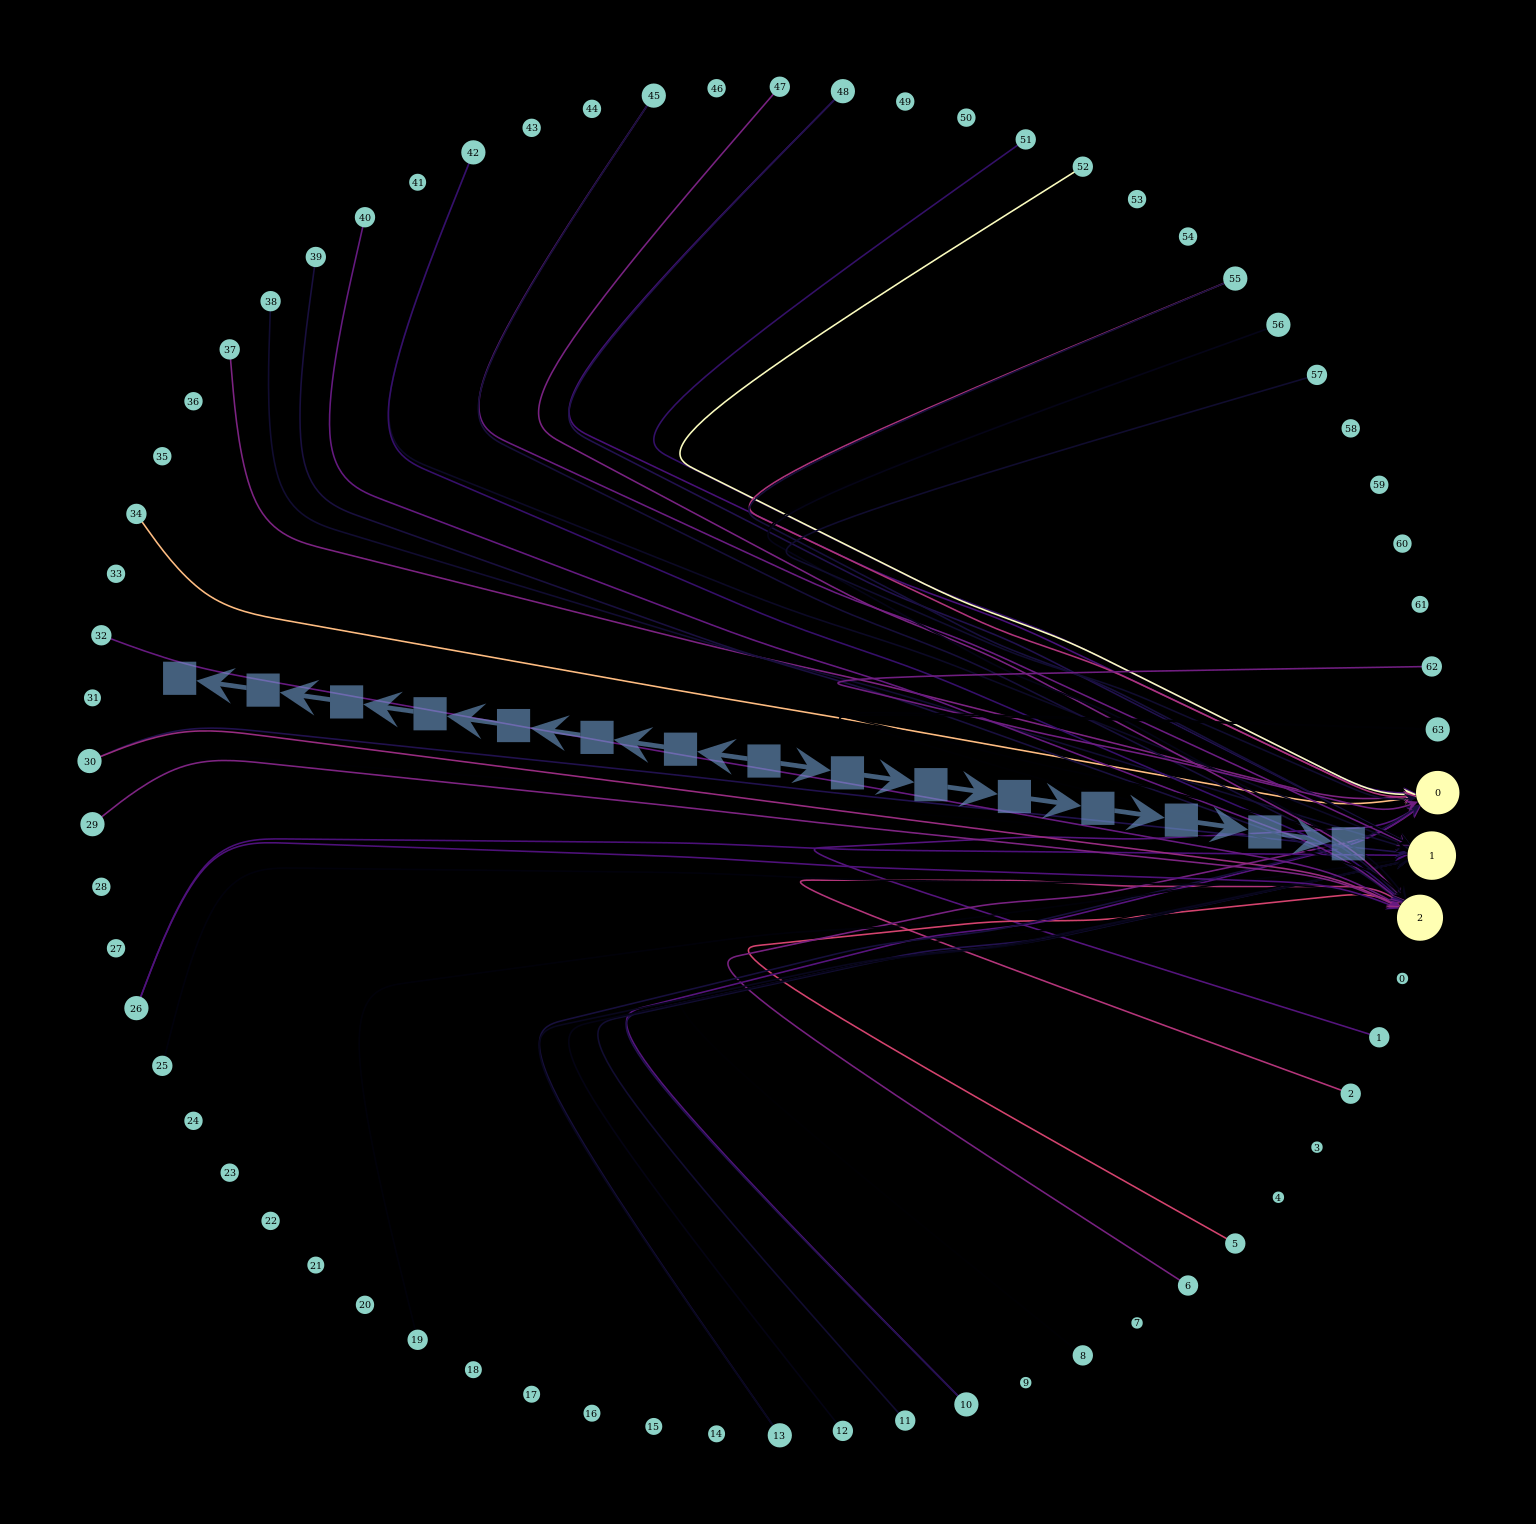

In [12]:
show_graph(gt_graph)

In [13]:
l1_node_map = get_node_map_by_layer(nx_graph, 0)
inv_l1_map = {v: k for k, v in l1_node_map.items()}

l2_node_map = get_node_map_by_layer(nx_graph, 1)
l2_node_map

{0: '9c124740f75111ed99c554bf643b94cf',
 1: '9c1247c2f75111ed99c554bf643b94cf',
 2: '9c124858f75111ed99c554bf643b94cf'}

In [14]:
train_iter = iter(dataset.train)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

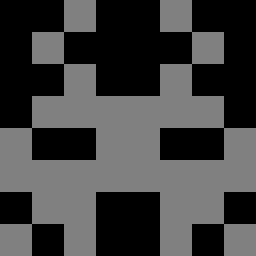

class:      2
pred_class: 2
confs:      [2.4e-07 6.0e-08 1.0e+00]


{0: 0, 1: 7, 2: 14}

In [19]:
dataset_item = next(train_iter)
pred, confs = model.dataset_item_predict(dataset_item)
show_image(dataset_item)

print(f"class:      {dataset_item['y']}")
print(f"pred_class: {pred}")
print(f"confs:      {confs.astype('float16')}")

image = dataset_item["img_features"].numpy().astype("uint8")
non_zero_idx = np.nonzero(image)[0]

l1_active_nodes = set(l1_node_map[idx] for idx in non_zero_idx)
l2_paths = {
    num_class: [
        inv_l1_map[node] for node
        in nx.ancestors(nx_graph, class_node).intersection(l1_active_nodes)
    ]
    for num_class, class_node in l2_node_map.items()
}

l2_path_cnt = {k: len(v) for k, v in l2_paths.items()}
l2_path_cnt

In [ ]:
l2_paths

In [ ]:
sorted(flatten(l2_paths.values()))